# Further Steps Towards a Standard Testbed for Optical Music Recognition

This Notebook serves as a guide to the Python interface of the MUSCIMA++ dataset, described in the publication "Further Steps Towards a Standard Testbed for Optical Music Recognition" by Hajič jr., Novotný, Pecina and Pokorný, ISMIR 2016.

## Requirements

To complete this tutorial, you will need:

* Python 2.7.11 + scientific stack (numpy, scipy, matplotlib -- we recommend using Anaconda)

Further Python packages you will need:

* OpenCV 3

You will also need the CVC-MUSCIMA dataset, found here:

http://www.cvc.uab.es/cvcmuscima/

Set the environmental variable `CVC_MUSCIMA_ROOT` to point to the root directory of the dataset.

Set the environmental variable `MFF_MUSCIMA_ROOT` to point to `muscima++/data/MFF-MUSCIMA`. 

Read the `muscima++/README.md` file (the README in this directory) to understand the relationship between CVC- and MFF-MUSCIMA and the details of the MFF-MUSCIMA symbolic and XML layers.

### Our code

The MUSCIMA++ interface code is in package `muscima`, in `muscima++/code/`. To install, we recommend using `pip wheel .` and `pip install *.whl`.



Throughout the rest of the notebook, we will assume you are in the `supplementary/muscima++` directory.

In [1]:
cd ~/mhr/publications/ismir2016/supplementary/muscima++

/Users/hajicj/mhr/publications/ismir2016/supplementary/muscima++


## The CVC-MUSCIMA Interface

We will first explore the `MUSCImage` class, which is the interface to CVC-MUSCIMA.

The CVC-MUSCIMA dataset is indexed by three variables: the *score number*, the *writer*, and the *distortion*.
There are 20 scores (numbered 1 - 20), 50 writers (numbered 1 - 50) and 12 distortion types, with the non-distorted
image filed under distortion type `'ideal'`.

In [6]:
import muscima as mm

img = mm.MUSCImage(writer=15, number=10)

The `MUSCImage` class implements access to the full, symbols-only and staff-only versions of the image:

In [10]:
full = img.full
symbols = img.symbols
staff_only = img.staff_only

Let's have a look:

In [21]:
import matplotlib.pyplot as plt

# This makes Jupyter render the matplotlib figures inside the notebook:
%matplotlib inline
# And this makes it render the figures at a good enough size:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (30.0, 20.0)

# Utility functions for plotting
def show_grayscale(img):
    plt.imshow(img, cmap='gray', interpolation='nearest')
    plt.show()
    
def show_grayscale_list(imgs, row_length=3):
    n_imgs = len(imgs)
    n_rows = n_imgs / row_length + 1
    n_cols = min(n_imgs, row_length)
    for i, img in enumerate(imgs):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img, cmap='gray', interpolation='nearest')
    plt.show()


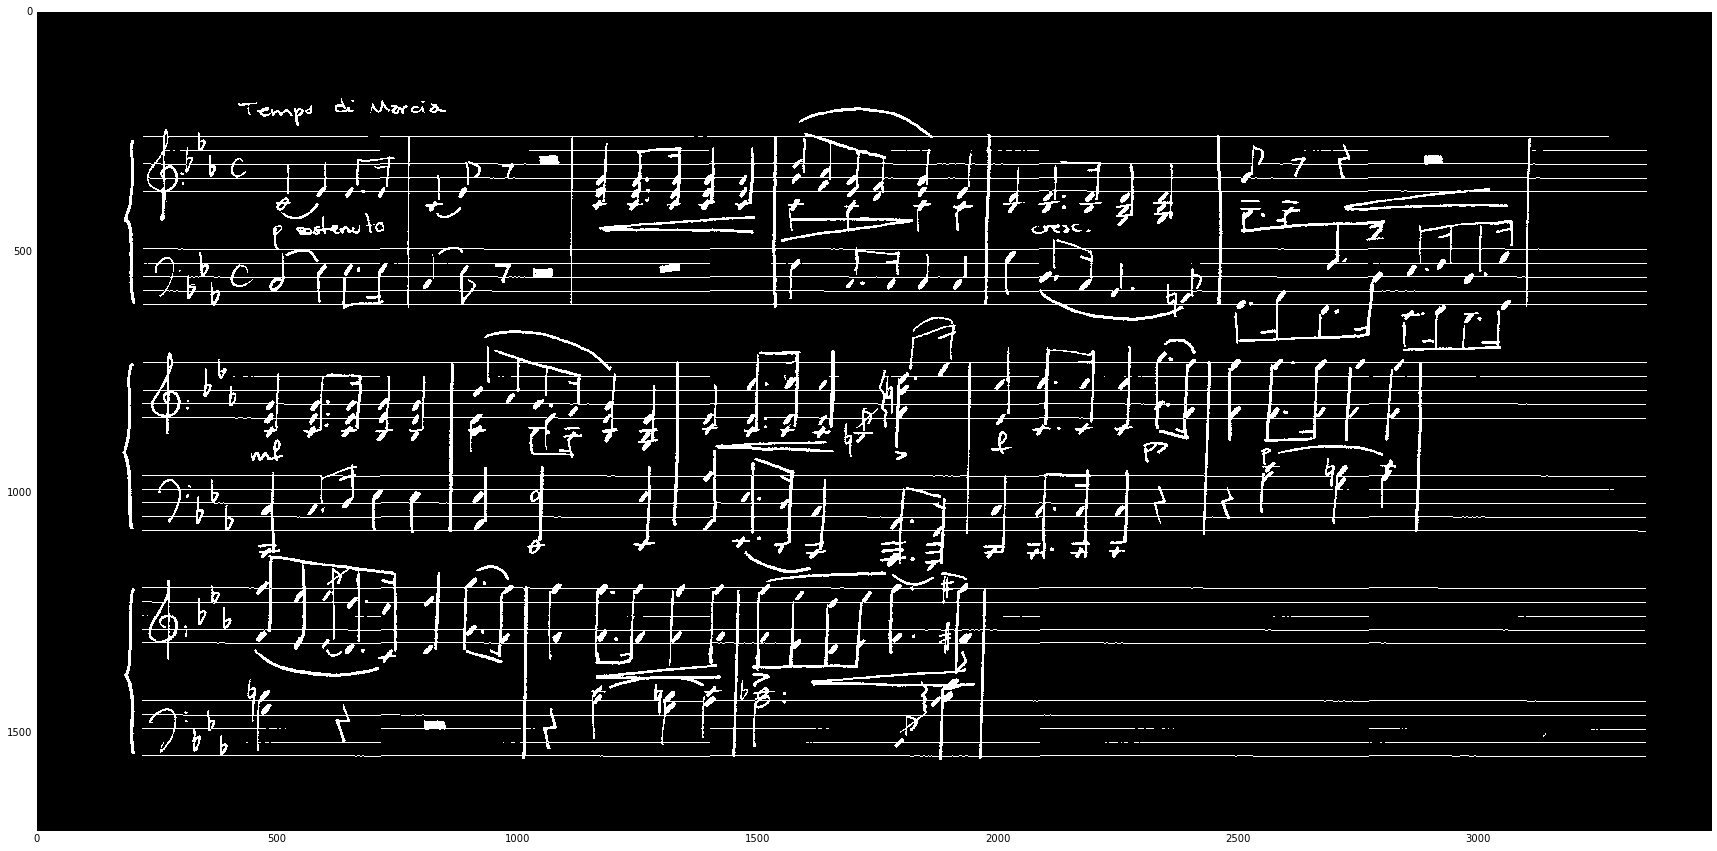

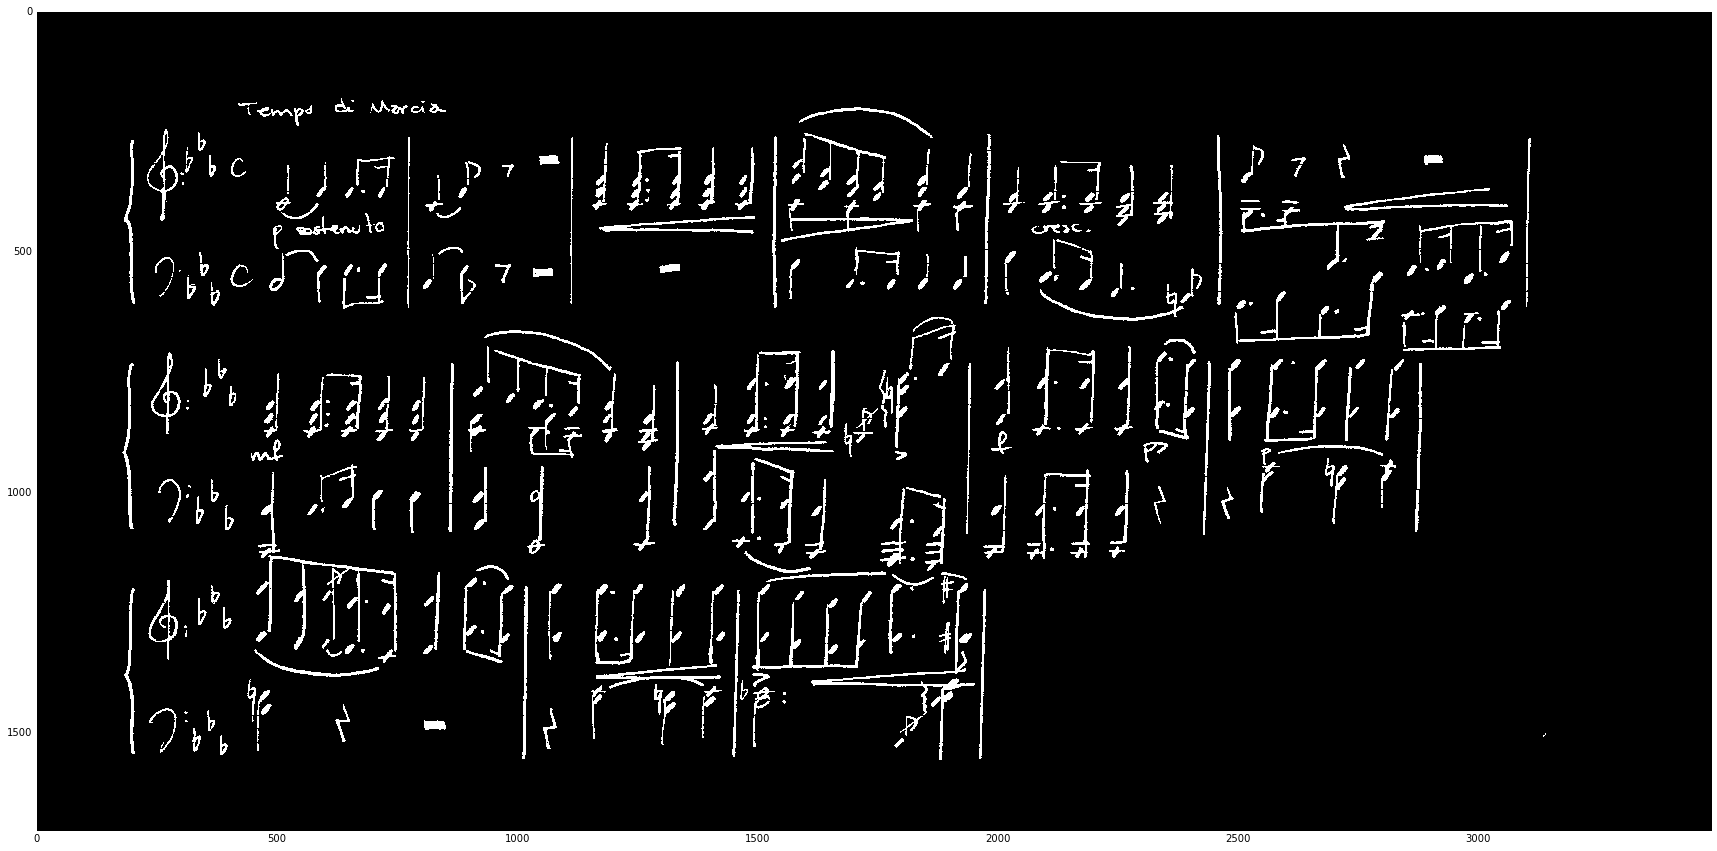

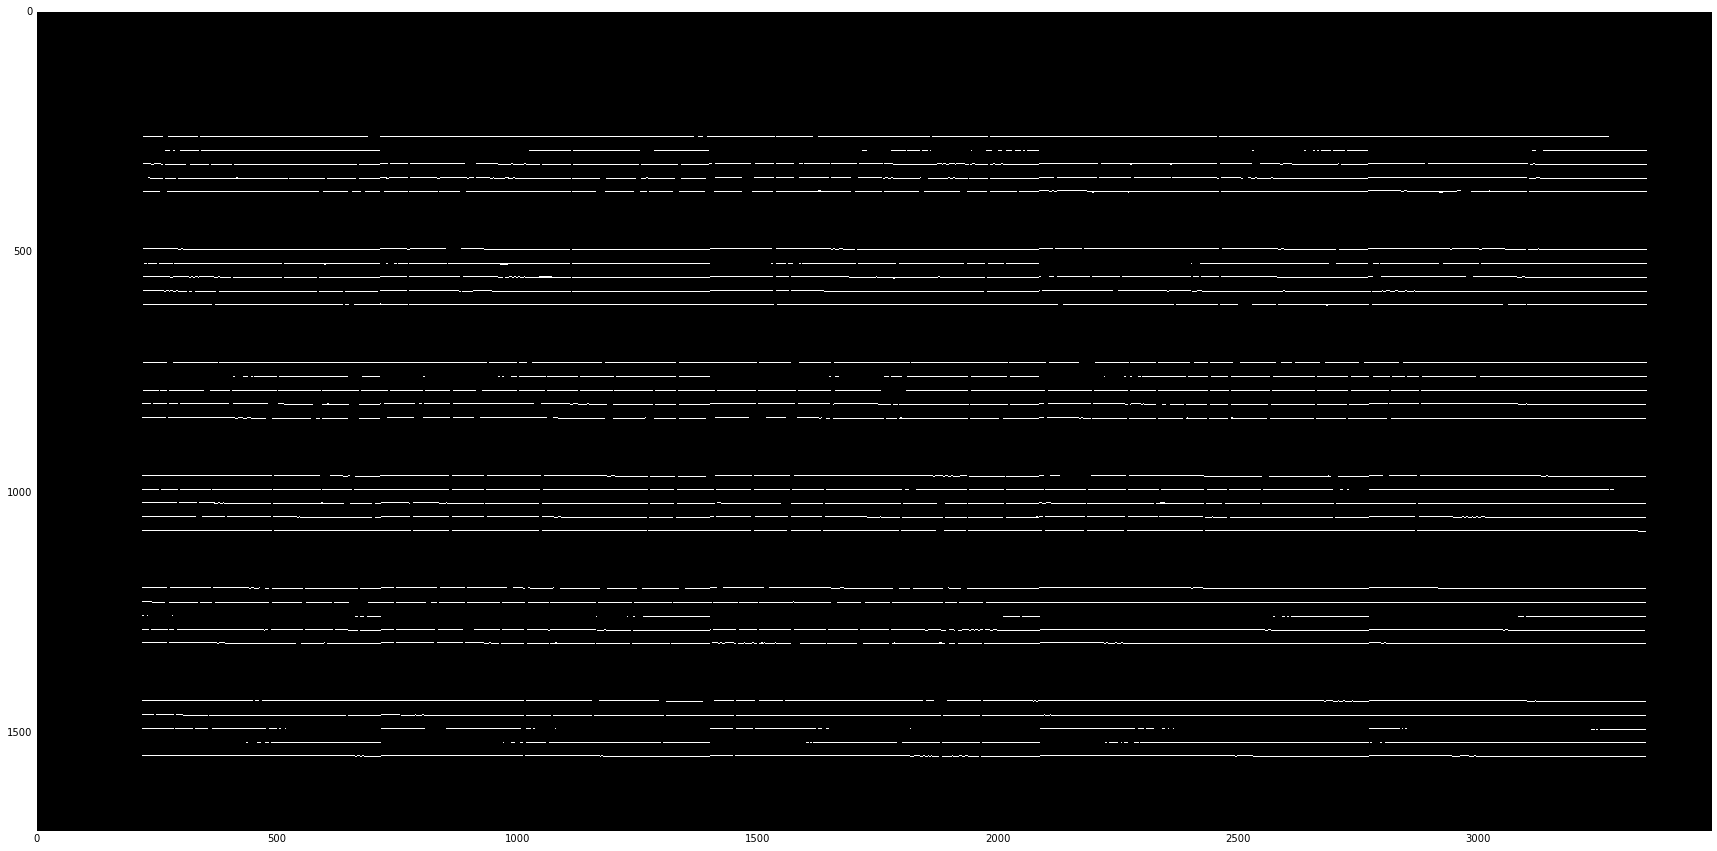

In [22]:
show_grayscale(full)
show_grayscale(symbols)
show_grayscale(staff_only)

The list of available distortions is available as a Python variable as well:

In [29]:
mm.CVC_MUSCIMA_DISTORTIONS

[u'curvature',
 u'ideal',
 u'interrupted',
 u'kanungo',
 u'rotated',
 u'staffline-thickness-variation-v1',
 u'staffline-thickness-variation-v2',
 u'staffline-y-variation-v1',
 u'staffline-y-variation-v2',
 u'thickness-ratio',
 u'typeset-emulation',
 u'whitespeckles']

Aside from this functionality, `MUSCImage` can also retrieve the bounding boxes of connected components on the symbol-level image:

[0, 0, 1703, 3485]
[181, 619, 211, 659]
[185, 654, 190, 659]
[186, 692, 214, 735]
[187, 799, 192, 807]
[190, 418, 217, 458]
[192, 816, 213, 851]
[196, 557, 215, 573]
[196, 736, 215, 771]
[197, 778, 213, 809]


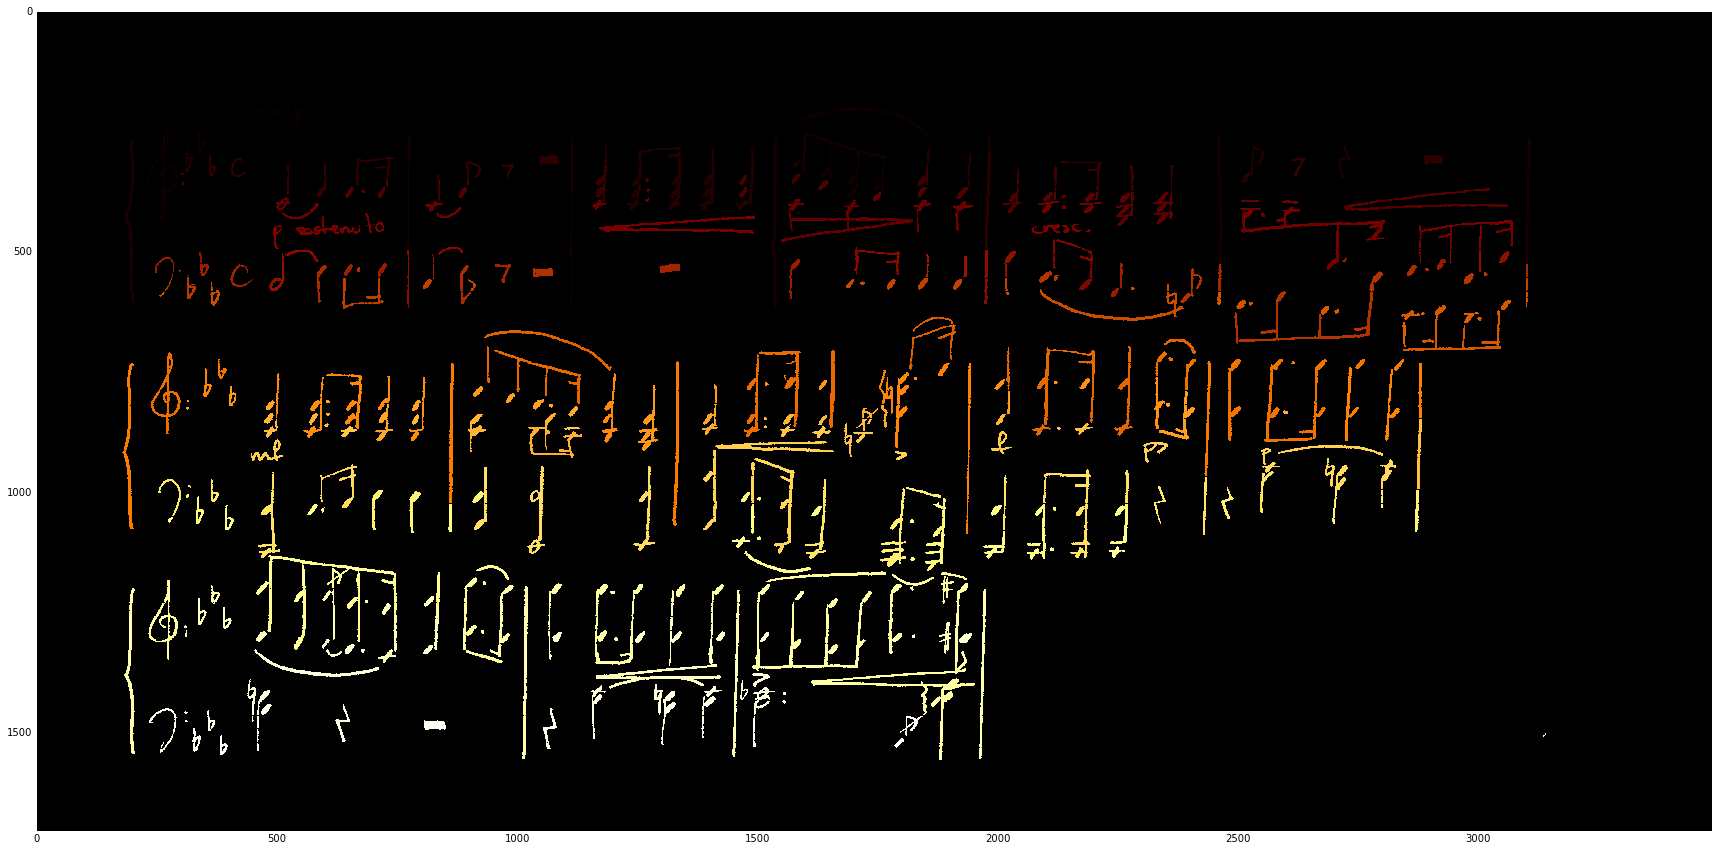

In [23]:
bboxes = img.symbol_bboxes()

# The bounding boxes are a dictionary indexed by the connected component label.
print '\n'.join(['{0}'.format(bboxes[b]) for b in bboxes.keys()[:10]])

# We can also get the connected component map from OpenCV, "labels"
bboxes, labels = img.symbol_bboxes(with_labels=True)
plt.imshow(labels, cmap='afmhot', interpolation='nearest')
plt.show()

The colormap starts from black and the labels start from top-left and number 1, so the first symbols are very dark. To get a better view, we could do this:

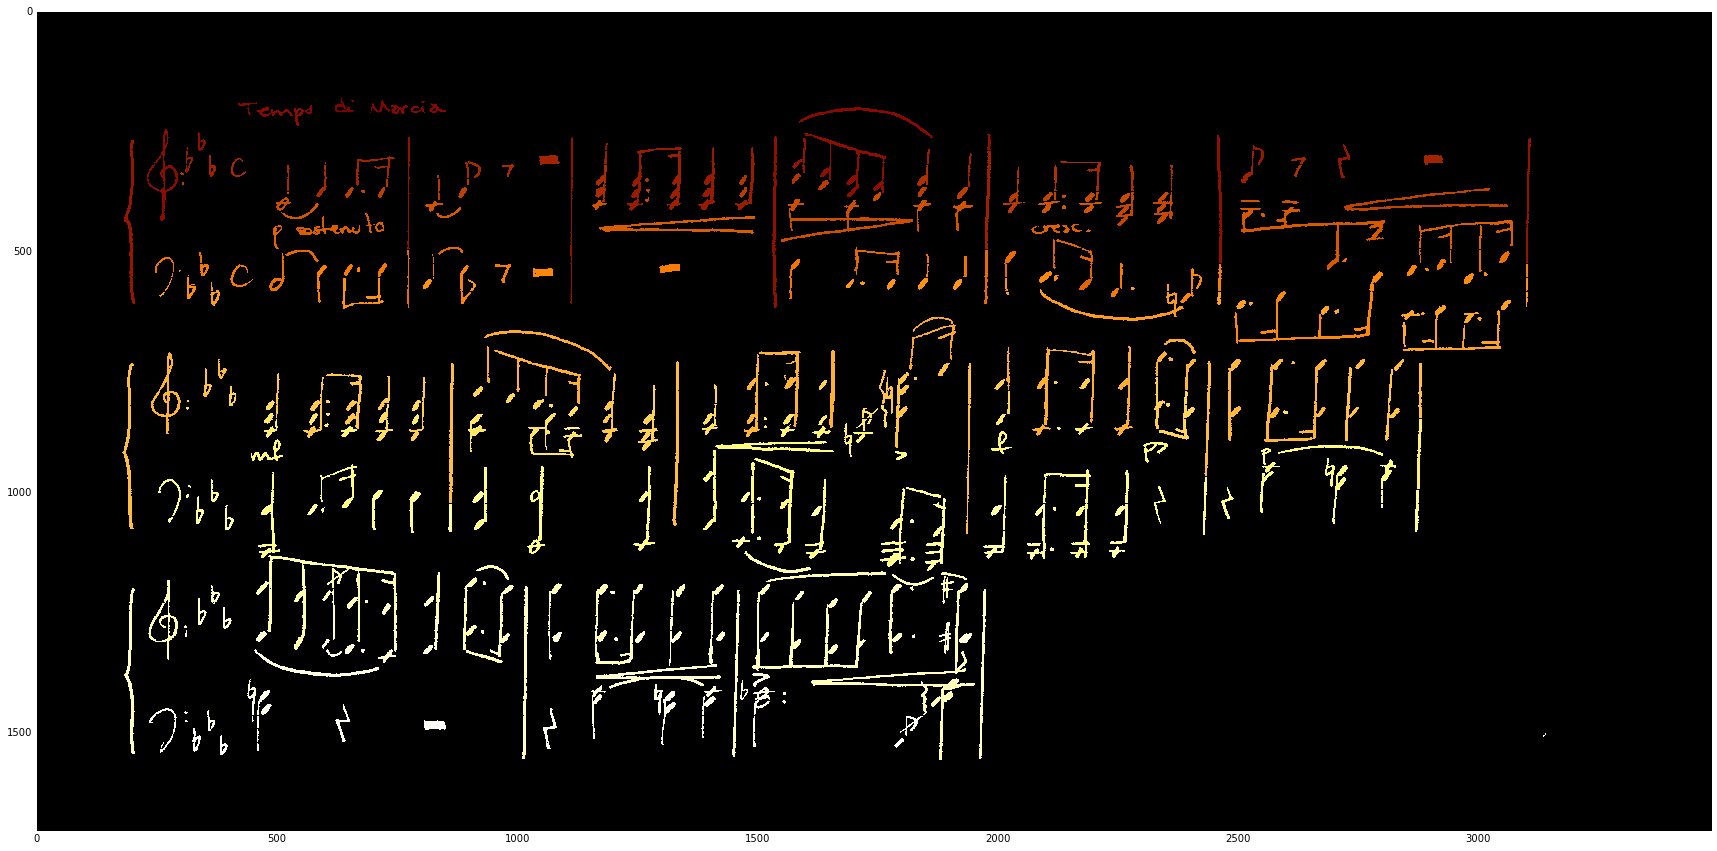

In [24]:
labels[labels > 0] += 150
plt.imshow(labels, cmap='afmhot', interpolation='nearest')
plt.show()

For details, refer to the documentation of OpenCV's `cv2.ConnectedComponents()` function.

`MUSCImage` can also directly provide the crops of the connected components:

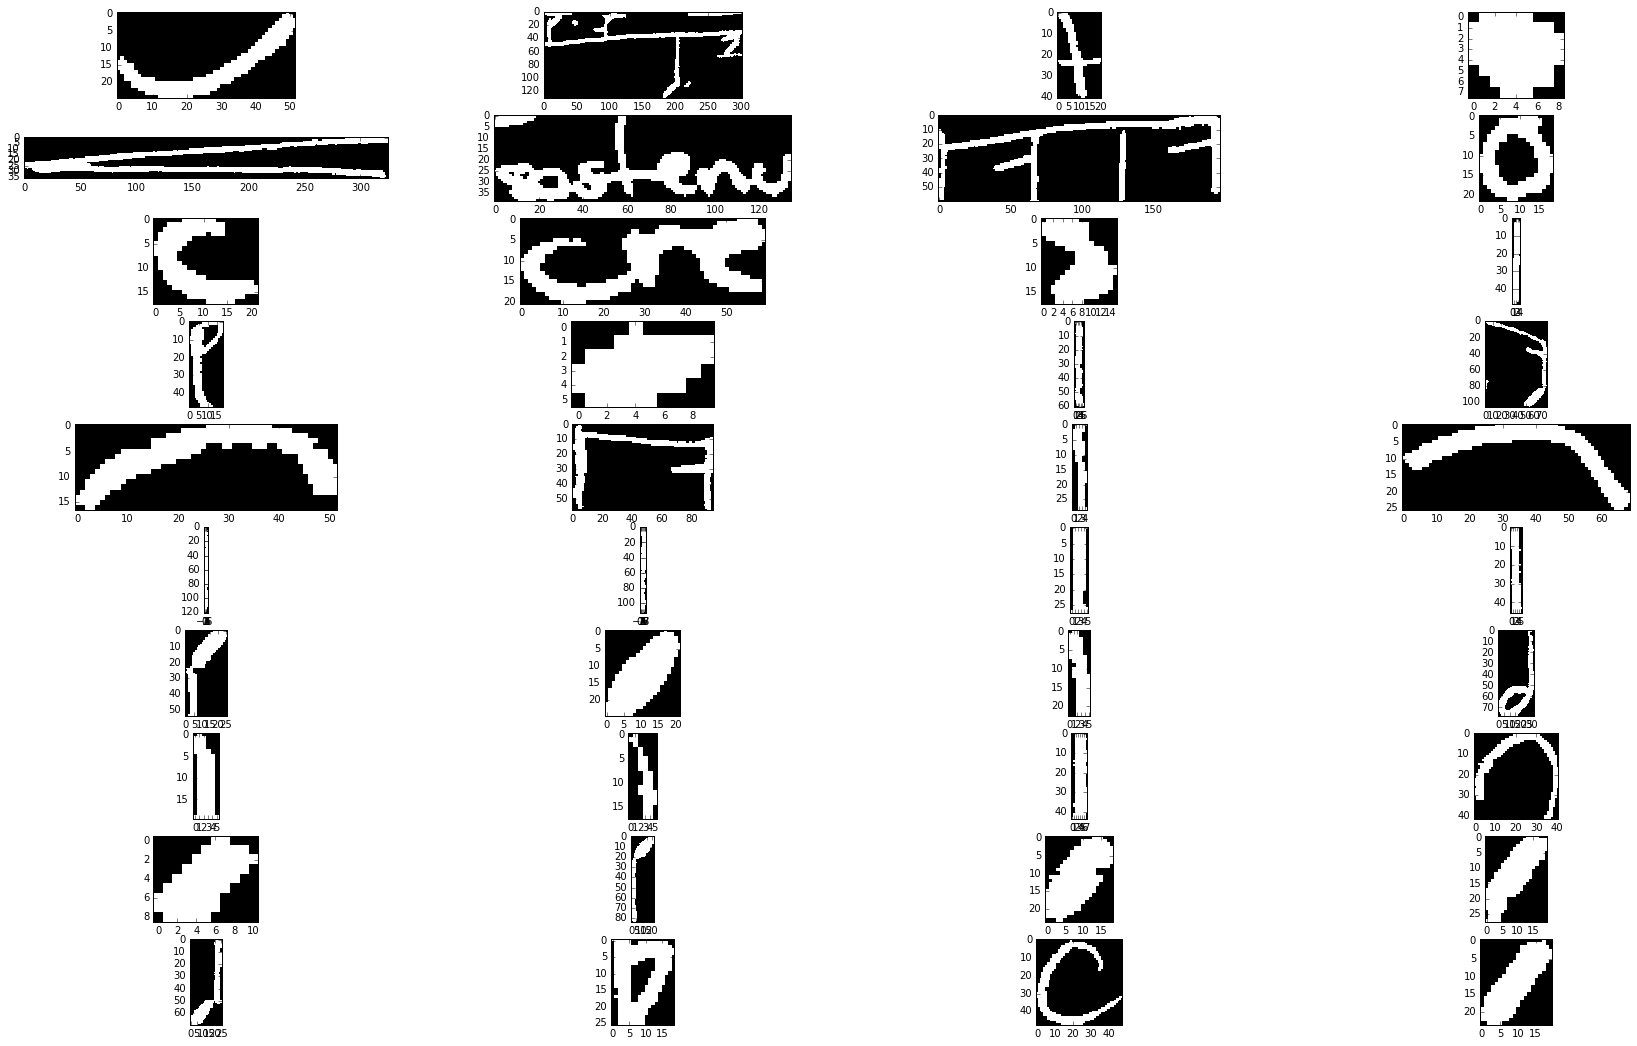

In [28]:
crops = img.symbol_crops()

show_grayscale_list(crops[100:140], row_length=4)

However, as you can see, connected components do not translate to individual symbols too well (some do, some don't).

### The MFF-MUSCIMA Interface

Now, we will try out the interface to the MFF-MUSCIMA layers of MUSCIMA++. 

The MusicXML layer of MUSCIMA++ is easily serviced with any XML library such as `lxml`. We therefore have not implemented anything specific for it yet. However, we did define some data formats for the symbolic layer, so we provide handling for these.

There are three kinds of data objects at the symbolic level:

* The symbol classes definition, `MLClassList`
* The image that is being annotated
* The set of annotated bounding boxes labeled with classes from the given class list, `CropObjectList`.

The `MLClassList` and `CropObjectList` are XML files, with schema definitions in the `muscima++/data/symbolic/specification` folder. However, for convenience and interfacing with possible annotation apps, we implemented a Python representation of a `MLClass` and a `CropObject`, and corresponding parsing functions.

Also, we wanted to be able to visualize the symbol-level annotation, so we implemented that.

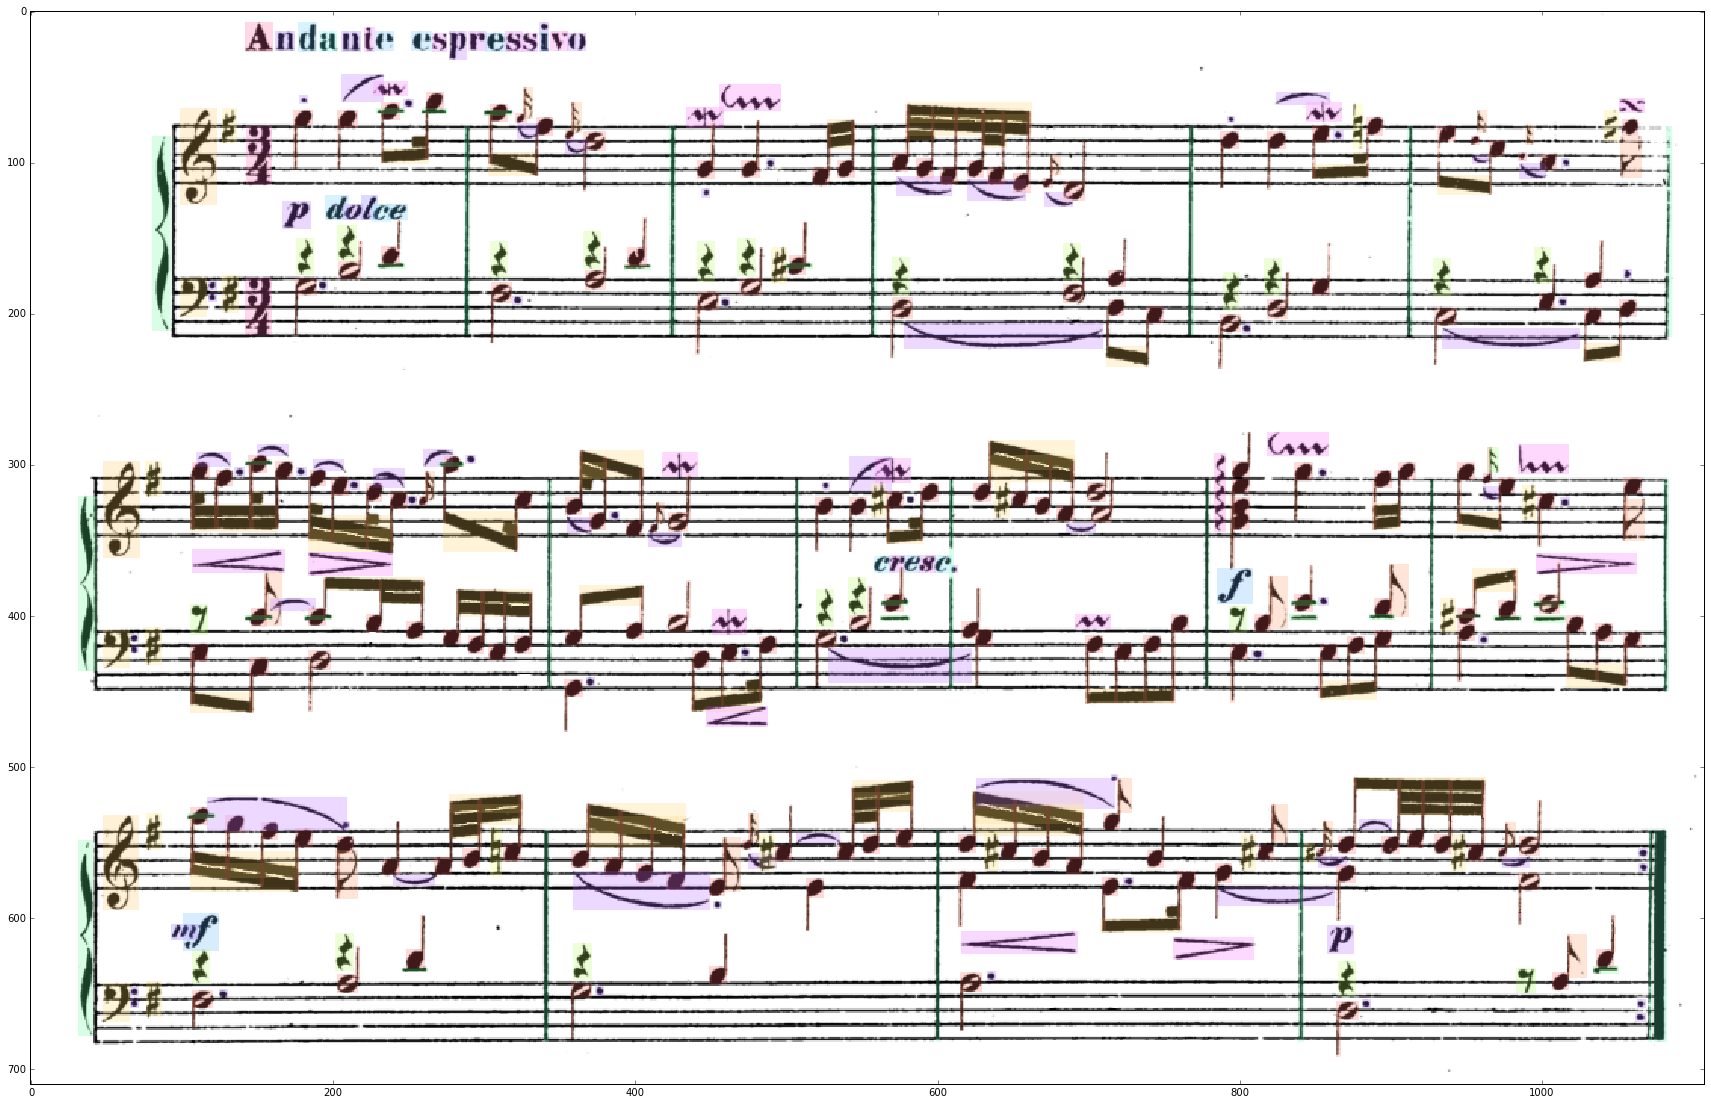

In [33]:
# Load the CropObjects
cropobjects = mm.parse_cropobject_list('data/Symbolic/data/F08.xml')

# Load the MLClassList
mlclasses = mm.parse_mlclass_list('data/Symbolic/specification/mff-muscima-mlclasses-primitives.xml')

import cv2
img = cv2.imread('data/Symbolic/data/F08.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Because of how RGB is represented as a triplet of values between 0 and 1, we need to cast
# the image as such:
img = img.astype('float32') / 255.0

r = mm.render_annotations(img, cropobjects, mlclasses)
plt.imshow(r, interpolation='nearest')
plt.show()

So we can now inspect annotation results visually. Of course, making an *editor* is quite another story...
(We have some tools in the works that we used to make the current prototype of MFF-MUSCIMA, but they are not remotely ready to be published yet.)